In [700]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii 
from astropy import units as u

In [701]:
tab = astropy.io.ascii.read("planets_2020.04.23_19.58.57.csv")

In [702]:
print(tab.colnames)
print(len(tab))

['pl_hostname', 'pl_letter', 'pl_name', 'pl_discmethod', 'pl_controvflag', 'pl_pnum', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_orbincllim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_denslim', 'pl_ttvflag', 'pl_kepflag', 'pl_k2flag', 'pl_nnotes', 'ra_str', 'ra', 'dec_str', 'dec', 'st_dist', 'st_disterr1', 'st_disterr2', 'st_distlim', 'gaia_dist', 'gaia_disterr1', 'gaia_disterr2', 'gaia_distlim', 'st_optmag', 'st_optmagerr', 'st_optmaglim', 'st_optband', 'gaia_gmag', 'gaia_gmagerr', 'gaia_gmaglim', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_rad', 'st_raderr1', 'st_raderr2',

## calculate contrast, separation, and select targets

In [704]:
contrast_arr = np.zeros((len(tab)))
sma_arr = np.zeros((len(tab)))
sep_arr = np.zeros((len(tab)))
rad_arr = np.zeros((len(tab)))
dis_arr = np.zeros((len(tab)))

def cal_rad(mass):
    if mass < (2.0 * u.earthMass):
        rad = (((mass / (1.0 * u.earthMass)).decompose())**(0.28) * u.earthRad).to(u.jupiterRad)
    elif mass < (0.41 * u.jupiterMass):
        rad = (((mass / (14.5 * u.earthMass)).decompose())**(0.59) * (4.01 * u.earthRad)).to(u.jupiterRad)
    elif mass < (0.08 * u.solMass):
        rad = ((mass / (1 * u.jupiterMass)).decompose())**(-0.04) * (1.1 * u.jupiterRad)
    else:
        rad = ((mass / (0.08 * u.solMass)).decompose())**(0.88) * (0.95 * u.jupiterRad) 
    return(rad)


for i, tmp in enumerate(tab["pl_name"]):
    if tab["pl_orbper"].mask[i] == False:
        # calculating sma
        if tab["pl_orbsmax"].mask[i] == True:
            if tab["st_mass"].mask[i] == True:
                sma = ((tab["pl_orbper"][i] / 365.0)**2 * 1.0)**(0.33) * u.AU
            else:
                sma = ((tab["pl_orbper"][i] / 365.0)**2 * tab["st_mass"][i])**(0.33) * u.AU
        else:
            sma = tab["pl_orbsmax"][i] * u.AU

        # calculating angular separation
        if tab["gaia_dist"].mask[i] == True:
            if tab["gaia_dist"].mask[i] == True:
                dis = 999 * u.parsec
            else:
                dis = tab["st_dist"][i] * u.parsec
        else:
            dis = tab["gaia_dist"][i] * u.parsec
        sep = ((sma / dis).decompose() * u.radian).to(u.arcsec)

        # calculating planet radius, https://arxiv.org/pdf/1603.08614.pdf
        if tab["pl_radj"].mask[i] == True:
            if tab["pl_bmassj"].mask[i] == False:
                mass = tab["pl_bmassj"][i] * u.jupiterMass
                rad = cal_rad(mass)
            else:
                rad = 1.0 * u.jupiterRad
        else:
            rad = tab["pl_radj"][i] * u.jupiterRad

        # calculating contrast
        albedo = 0.3
        con = ((rad / sma).decompose())**2 * albedo

        sma_arr[i] = sma.value
        sep_arr[i] = sep.value
        rad_arr[i] = rad.value
        contrast_arr[i] = con
        dis_arr[i] = dis.value
        
        if (con > 5e-7) & (sep.value > 15e-3):
            if tab["dec"][i] > 0.0:
                print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
                      dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i], \
                      tab["st_k"][i], tab["st_wise1"][i])
            else:
                print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
                      dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i], \
                      tab["st_k"][i], tab["st_wise1"][i])
#         elif tab["pl_name"][i] == "Ross 128 b":
#              print(tab["pl_name"][i], tab["pl_orbper"][i], sma.value, tab["pl_bmassj"][i], rad.value, \
#                   dis.value, tab["st_teff"][i], tab["st_mass"][i], con, sep.value, tab["dec"][i])           
        else:
            1 == 1
    else:
        sma_arr[i] = 1.0
        sep_arr[i] = 1e-5
        rad_arr[i] = 1.0
        contrast_arr[i] = 1e-10       
        dis_arr[i] = 1e3

55 Cnc c 44.4175 0.241376 0.1714 0.781144196188202 12.59 5196.0 0.91 7.175622329345894e-07 0.01917204130277134 28.330818 4.015 4.001
GJ 1148 b 41.38 0.166 0.30425 1.095899867063151 11.02 3264.0 0.35 2.9861450291544766e-06 0.015063520871261397 42.751972 6.822 6.672
GJ 3512 b 203.59 0.338 0.463 1.1344084308971603 9.49 3081.0 0.12 7.717751920507192e-07 0.03561643835644343 59.497391 8.668 --
GJ 876 b 61.1166 0.208317 2.2756 1.06440976008945 4.68 -- 0.32 1.788766262338664e-06 0.04451217948752824 -14.2637 5.01 4.863
GJ 876 c 30.0881 0.12959 0.7142 1.114910206695119 4.68 -- 0.32 5.071332979895513e-06 0.027690170940387893 -14.2637 5.01 4.863
HD 3651 b 62.25 0.295 0.228 0.9243711610616583 11.14 5221.0 0.8 6.727195786762944e-07 0.026481149012774798 21.250473 3.999 3.786
HIP 79431 b 111.7 0.36 2.1 1.0678344146073064 14.54 3368.0 0.42 6.028206892670875e-07 0.024759284731968402 -18.875504 6.589 6.508


## Plot selected targets

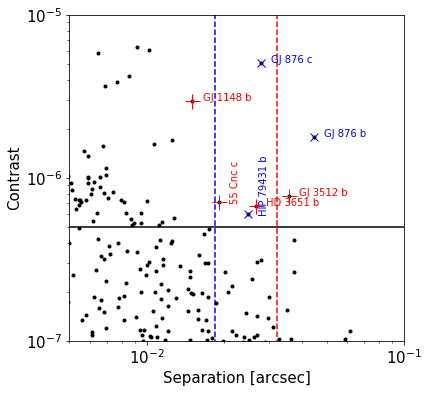

In [705]:
con_threshold = 5e-7
sep_threshold = 15e-3

plt.figure(figsize=(6,6))

font_size = 15
plt.plot(sep_arr, contrast_arr, 'k.')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Separation [arcsec]", fontsize=font_size)
plt.ylabel("Contrast", fontsize=font_size)
plt.gca().tick_params(labelsize=font_size)

plt.xlim(5e-3, 1e-1)
plt.ylim(1e-7, 1e-5)

lambda_D = (((3.5 * u.micron) / (22.4 * u.meter).decompose()) * u.radian).to(u.arcsec)
plt.vlines(lambda_D.value, 1e-10, 1e-5, color="red", linestyle="dashed")

lambda_D = (((2.0 * u.micron) / (22.4 * u.meter).decompose()) * u.radian).to(u.arcsec)
plt.vlines(lambda_D.value, 1e-10, 1e-5, color="blue", linestyle="dashed")

plt.hlines(5e-7, 1e-3, 1e-1, color="k", linestyle="solid")

ind = np.where((contrast_arr > con_threshold) & (sep_arr > sep_threshold))
rot_arr = np.array([90,0,0,0,0,0,90])
for ii, i in enumerate(np.array(ind).flatten()):
    if (tab["dec"][i] > 0.0):
        plt.plot(sep_arr[i], contrast_arr[i], color="r", ms=15, marker="+")
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.1, contrast_arr[i]), rotation=rot_arr[ii], color="red")
    else:
        plt.plot(sep_arr[i], contrast_arr[i], color="b", ms=8, marker="x")
        plt.annotate(tab["pl_name"][i], xy=(sep_arr[i] * 1.1, contrast_arr[i]), rotation=rot_arr[ii], color="blue")

![title](eq4.png)


In [706]:
# http://www.stsci.edu/~strolger/docs/UNITS.txt

import astropy.constants as ac

def cal_t0(mag=0.0, filt="K", SNR=5.0, R=1e5, pl_st_con=1e-5, aper=11.8, eta=0.1, q=0.95):
    if filt == "K":
        wav = 2.0 * u.micron
        f_zero = 3.90e-11 * u.erg / (u.cm)**2/ u.s / u.AA
    elif filt == "L":
        wav = 3.5 * u.micron
        f_zero = 8.1e-12 * u.erg / (u.cm)**2/ u.s / u.AA
        
    e_ph = ac.h * ac.c / wav
    f_zero = f_zero / e_ph
    
    f = f_zero / 2.512**(mag)
    A = np.pi * (aper / 2.0 * u.meter)**2 * 2.0 # two sub-apertures
    
    t0 = R * SNR**2 / (wav * pl_st_con**2 * f * A * q * eta)
    t0 = t0.decompose()
    
    return(t0)
    
    

![title](eq9.png)


In [708]:
def cal_tL(b=[1.0], w=[1e-1], t0 = None, eta_p=1e-1):
    tL = 0.0 * u.s
    for bi, wi in zip(b, w):
        tL = tL + t0 / (eta_p)**2 * (bi * wi)**2
    return(tL)

![](eq12.png)


In [632]:
def cal_tbg(t0=None, eta_p=1e-1, mag_bg=0.0, mag=0.0, fiber_area=1.0):
    # https://www2.keck.hawaii.edu/inst/nirc2/filters.html
    # skg bg = 12.2 in K and 2.9 in L
    f_bg_over_f_star = 2.512**(mag - mag_bg) * fiber_area # fiber_area in arcsec**2
    tbg = f_bg_over_f_star * t0 / (eta_p)**2
    return(tbg)

![](eq13.png)


In [635]:
def cal_dc(mag=0.0, filt="K", R=1e5, aper=11.8, eta=0.1, q=0.95, t0=None, eta_p=1e-1, i_dark=1.0, pixel_sampling=3.0):
    if filt == "K":
        wav = 2.0 * u.micron
        f_zero = 3.90e-11 * u.erg / (u.cm)**2/ u.s / u.AA
    elif filt == "L":
        wav = 3.5 * u.micron
        f_zero = 8.1e-12 * u.erg / (u.cm)**2/ u.s / u.AA
        
    e_ph = ac.h * ac.c / wav
    f_zero = f_zero / e_ph
    
    f = f_zero / 2.512**(mag)
    A = np.pi * (aper / 2.0 * u.meter)**2
    
    signal_pixel = (f * wav *  A * q * eta / (R * pixel_sampling)).decompose()
    dc_pixel = i_dark / u.s
    
    tdc = (dc_pixel / signal_pixel * t0 / (eta_p)**2).decompose()
    
    return(tdc)

![](eq14.png)

In [638]:
def cal_trd(Nrd=2.0, eta_s=1e-5, eta_p=1e-1, t0=None, W=2**16):
    trd = Nrd**2 / W * eta_s / (eta_p)**2 * t0
    return(trd)


![](eq7.png)

In [642]:
def cal_tfs(Rs=1.0, dis=10.0, aper=22.8, filt="K", t0=None, eta_p=1e-1):
    if filt == "K":
        wav = 2.0 * u.micron
    elif filt == "L":
        wav = 3.5 * u.micron

    Rs = Rs * u.solRad
    dis = dis * u.parsec
    aper = aper * u.meter
    
    tfs = (Rs / dis / np.sqrt(12) * aper / wav)**2 / (eta_p)**2 * t0
    tfs = tfs.decompose()
    return(tfs)

## Now let's put all togher to calculate the required exposure time for a target

In [710]:
def find_eta_p(sep):
    tab = astropy.io.ascii.read("sep_eta_p_charge_1.txt")
    x = tab["col1"]
    y = tab["col2"]
    return(np.interp(sep, x, y))
    

In [711]:
def calc_total_time(star_name=None, filt="K", mag_bg=12.2, b_arr=b_arr, w_arr=w_arr, eta=0.1, baseline=22.8):
    
    eta_s = np.sum((b_arr * w_arr)**2)

    ind = np.where(tab["pl_name"] == star_name)[0][0]
    pl_st_con = contrast_arr[ind]
    sep = sep_arr[ind]
    aper = 8.4
    baseline = 22.4
    q = 0.95
    R = 1e5
    pixel_sampling = 3.0
    SNR = 5.0
    if tab["st_rad"].mask[ind] == False:
        Rs = tab["st_rad"][ind]
    else:
        if tab["st_mass"].mask[ind] == False:
            mass = tab["st_mass"][ind] * u.solMass
            Rs = cal_rad(mass).to(u.solRad).value
        else:
            Rs = 999.0 
    
    dis = dis_arr[ind]
    
    if filt == "K":
        mag = tab["st_k"][ind]
        wav = 2.0 * u.micron
    elif filt == "L":
        wav = 3.5 * u.micron
        if tab["st_wise1"].mask[ind] == False:
            mag = tab["st_wise1"][ind]
        else:
            mag = tab["st_k"][ind]
    else:
        wav = 999 * u.micron
        mag = 999
        
    lambda_D = ((wav / (baseline * u.meter)).decompose() * u.radian).to(u.arcsec)
        
    if baseline != aper:
        fiber_area = np.pi * ((((1.4 * wav / (baseline * u.meter) / 2.0).decompose()) * u.radian).to(u.arcsec).value)**2
        fiber_area = fiber_area / (baseline / aper / np.sqrt(2))
    else:
        fiber_area = np.pi * ((((1.4 * wav / (baseline * u.meter) / 2.0).decompose()) * u.radian).to(u.arcsec).value)**2

    Nrd = 2.0
    W = 2**16
    i_dark = 1e-2

    t0 = cal_t0(mag=mag, filt=filt, SNR=SNR, R=R, pl_st_con=pl_st_con, aper=aper, eta=eta, q=q)
    
    eta_p = find_eta_p(sep / lambda_D.value)

    tfs = cal_tfs(Rs=Rs, dis=dis, aper=baseline, filt=filt, t0=t0, eta_p=eta_p)

    tL = cal_tL(b=b_arr, w=w_arr, t0 = t0, eta_p=eta_p)

    tbg = cal_tbg(t0=t0, eta_p=eta_p, mag_bg=mag_bg, mag=mag, fiber_area=fiber_area)

    trd = cal_trd(Nrd=Nrd, eta_s=eta_s, eta_p=eta_p, t0=t0, W=W)

    tdc = cal_dc(mag=mag, filt=filt, R=R, aper=aper, eta=eta, q=q, t0=t0, eta_p=eta_p, i_dark=i_dark, \
             pixel_sampling=pixel_sampling)

    t_total = tfs + tL + tbg + trd + tdc
    
    with open(star_name+".txt", "wb") as f:
        f.write(bytes("\multicolumn{4}{c}{\\bf{Star Parameters}}\\\\\n", "UTF-8"))
        f.write(bytes("star name\t\t&=& {0:<30s}&\\\\\n".format(star_name), "UTF-8"))
        f.write(bytes("magnitude\t\t&=& {0:<6.2f} &mag\\\\\n".format(mag), "UTF-8"))
        f.write(bytes("distance\t\t&=& {0:<10.2f} &pc\\\\\n".format(dis), "UTF-8"))
        f.write(bytes("star radius\t\t&=& {0:<6.2f} &solar radii\\\\\n".format(Rs), "UTF-8"))
        f.write(bytes("planet-star contrast\t&=& {0:<8.2e}&\\\\\n".format(pl_st_con), "UTF-8"))
        f.write(bytes("planet-star separation\t&=& {0:<8.2f} &mas\\\\\n".format(sep * 1e3), "UTF-8"))
        f.write(bytes("\multicolumn{4}{c}{\\bf{Telescope Parameters}}\\\\\n", "UTF-8"))
        f.write(bytes("aperture\t\t&=& {0:<8.2f} &meter\\\\\n".format(aper), "UTF-8"))
        f.write(bytes("baseline\t\t&=& {0:<8.2f} &meter\\\\\n".format(baseline), "UTF-8"))
        f.write(bytes("wavelength\t\t&=& {0:<8.2f} &um\\\\\n".format(wav.value), "UTF-8"))
        f.write(bytes("lambda/D\t\t&=& {0:<8.2f} &mas\\\\\n".format(lambda_D.value * 1e3), "UTF-8"))
        f.write(bytes("\multicolumn{4}{c}{\\bf{Coronagraph Parameters}}\\\\\n", "UTF-8"))
        f.write(bytes("filter\t\t\t&=& {0:<10s}&\\\\\n".format(filt), "UTF-8"))
        f.write(bytes("starlight suppression\t&=& {0:<8.2e}&\\\\\n".format(eta_s), "UTF-8"))
        f.write(bytes("planet throughput\t&=& {0:<8.2e}&\\\\\n".format(eta_p), "UTF-8"))
        f.write(bytes("bmn array\t\t&=& {0:<100s}&\\\\\n".format(str(b_arr)), "UTF-8"))
        f.write(bytes("aberration array\t&=& {0:<100s}&\\\\\n".format(str(w_arr)), "UTF-8"))
        f.write(bytes("\multicolumn{4}{c}{\\bf{Spectrograph Parameters}}\\\\\n", "UTF-8"))
        f.write(bytes("required SNR\t\t&=& {0:<8.1f}&\\\\\n".format(SNR), "UTF-8"))
        f.write(bytes("background\t\t&=& {0:<6.2f} &mag / arcsec**2\\\\\n".format(mag_bg), "UTF-8"))
        f.write(bytes("spectral resolution\t&=& {0:<8.0f}&\\\\\n".format(R), "UTF-8"))
        f.write(bytes("pixel sampling rate\t&=& {0:<5.1f} &pixel per resolution element\\\\\n".format(pixel_sampling), "UTF-8"))
        f.write(bytes("system throughput\t&=& {0:<6.3f}&\\\\\n".format(eta), "UTF-8"))
        f.write(bytes("fiber size\t\t&=& {0:<8.2e} &arcsec**2\\\\\n".format(fiber_area), "UTF-8"))
        f.write(bytes("\multicolumn{4}{c}{\\bf{Detector Parameters}}\\\\\n", "UTF-8"))
        f.write(bytes("dark current\t\t&=& {0:<8.2e} &electron/pixel/s\\\\\n".format(i_dark), "UTF-8"))
        f.write(bytes("readout noise\t\t&=& {0:<8.4f} &electron/read\\\\\n".format(Nrd), "UTF-8"))
        f.write(bytes("quantum efficiency\t&=& {0:<6.3f}&\\\\\n".format(q), "UTF-8"))
        f.write(bytes("well depth\t\t&=& {0:<8.0f} &ADU\\\\\n".format(W), "UTF-8"))
        f.write(bytes("\multicolumn{4}{c}{\\bf{Exposure Times}}\\\\\n", "UTF-8"))
        f.write(bytes("t0\t\t\t&=& {0:<10.5e} &s\\\\\n".format(t0.value), "UTF-8"))
        f.write(bytes("finite star time\t&=& {0:<10.5e} &s\\\\\n".format(tfs.value), "UTF-8"))
        f.write(bytes("low order time\t\t&=& {0:<10.5e} &s\\\\\n".format(tL.value), "UTF-8"))
        f.write(bytes("background time\t\t&=& {0:<10.5e} &s\\\\\n".format(tbg.value), "UTF-8"))
        f.write(bytes("readout noise time\t&=& {0:<10.5e} &s\\\\\n".format(trd.value), "UTF-8"))
        f.write(bytes("dark current time\t&=& {0:<10.5e} &s\\\\\n".format(tdc.value), "UTF-8"))
        f.write(bytes("total time\t\t&=& {0:<10.5e} &s\\\\\n".format(t_total.value), "UTF-8"))
        f.write(bytes("total time\t\t&=& {0:<10.2f} &hour\\\\\n".format(t_total.to(u.hour).value), "UTF-8"))

    print("total time = ", t_total.to(u.hour))
    print("More detals in "+star_name+".txt")
    print("{0:20s} & {1:6.1f} & {2:5.1f} & & {3:6.3f} & {4:6.2f} & {5:8.2e} & {6:6.1f} & {7:5.2f} & {8:10.2f} & & \\\\\n".format(\
        star_name, dis, mag, sma_arr[ind], rad_arr[ind], pl_st_con, sep_arr[ind] * 1e3, sep_arr[ind] / lambda_D.value, \
        t_total.to(u.hour).value))

    

## K band results

In [714]:
b_arr = np.array([2.00, 0.43, 0.50, 0.31, 0.21, 0.39, 0.06, 0.04, 0.17, 0.09])
w_arr = np.array([1e-2] * len(b_arr))
mag_bg = 12.2
filt = "K"
eta = 0.1


In [715]:

calc_total_time(star_name="55 Cnc c", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="GJ 1148 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="GJ 3512 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="HD 3651 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="GJ 876 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="GJ 876 c", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="HIP 79431 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

total time =  5548.002169682297 h
More detals in 55 Cnc c.txt
55 Cnc c             &   12.6 &   4.0 & &  0.241 &   0.78 & 7.18e-07 &   19.2 &  1.04 &    5548.00 & & \\

total time =  2572.6710366333073 h
More detals in GJ 1148 b.txt
GJ 1148 b            &   11.0 &   6.8 & &  0.166 &   1.10 & 2.99e-06 &   15.1 &  0.82 &    2572.67 & & \\

total time =  197325830.5124276 h
More detals in GJ 3512 b.txt
GJ 3512 b            &    9.5 &   8.7 & &  0.338 &   1.13 & 7.72e-07 &   35.6 &  1.93 & 197325830.51 & & \\

total time =  181110.67815354883 h
More detals in HD 3651 b.txt
HD 3651 b            &   11.1 &   4.0 & &  0.295 &   0.92 & 6.73e-07 &   26.5 &  1.44 &  181110.68 & & \\

total time =  167401.74958078846 h
More detals in GJ 876 b.txt
GJ 876 b             &    4.7 &   5.0 & &  0.208 &   1.06 & 1.79e-06 &   44.5 &  2.42 &  167401.75 & & \\

total time =  23642.152562922176 h
More detals in GJ 876 c.txt
GJ 876 c             &    4.7 &   5.0 & &  0.130 &   1.11 & 5.07e-06 &   27.7 &  1.5

## L band results

In [718]:
b_arr = np.array([2.00, 0.43, 0.50, 0.31, 0.21, 0.39, 0.06, 0.04, 0.17, 0.09])
w_arr = np.array([1e-2] * len(b_arr))
mag_bg = 2.0
filt = "L"
eta = 0.1

In [719]:

calc_total_time(star_name="55 Cnc c", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="GJ 1148 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="GJ 3512 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="HD 3651 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="GJ 876 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="GJ 876 c", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

calc_total_time(star_name="HIP 79431 b", filt=filt, mag_bg=mag_bg, b_arr=b_arr, w_arr=w_arr, eta=eta)

total time =  72275.03529433919 h
More detals in 55 Cnc c.txt
55 Cnc c             &   12.6 &   4.0 & &  0.241 &   0.78 & 7.18e-07 &   19.2 &  0.59 &   72275.04 & & \\

total time =  910411.2869261988 h
More detals in GJ 1148 b.txt
GJ 1148 b            &   11.0 &   6.7 & &  0.166 &   1.10 & 2.99e-06 &   15.1 &  0.47 &  910411.29 & & \\

total time =  571176211.3427496 h
More detals in GJ 3512 b.txt
GJ 3512 b            &    9.5 &   8.7 & &  0.338 &   1.13 & 7.72e-07 &   35.6 &  1.11 & 571176211.34 & & \\

total time =  45337.588163709326 h
More detals in HD 3651 b.txt
HD 3651 b            &   11.1 &   3.8 & &  0.295 &   0.92 & 6.73e-07 &   26.5 &  0.82 &   45337.59 & & \\

total time =  986075.3611719491 h
More detals in GJ 876 b.txt
GJ 876 b             &    4.7 &   4.9 & &  0.208 &   1.06 & 1.79e-06 &   44.5 &  1.38 &  986075.36 & & \\

total time =  5626.369359193455 h
More detals in GJ 876 c.txt
GJ 876 c             &    4.7 &   4.9 & &  0.130 &   1.11 & 5.07e-06 &   27.7 &  0.86 &